# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 970988852
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 0.001,
    "warmup_factor": 5,
    'scheduler': 'cosine_schedule_with_warmup',
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_from_steps": -1,
    'to_freeze_count': 0,
    "seed": seed,
    "num_epoch": 100
}

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon, a dragon, and a dragon's dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have a dragon dragon. I have


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-e7ec7a34552d2c73/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>facin2<msg>An "So you come to me on the basis of rumors? Is that how you operate? What do you want from me?"<|endoftext|><d><scn>office<msg>Sb "What you've learned about the map is fascinating, if not a little unsettling. While it's good to have confirmed its origin, to know that it came from your world is something else."<|endoftext|><p><msg>c "What's the most embarrassing thing that ever happened to you?"<|endoftext|><p><msg>c "Lorem? Is that you?"<d><
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


Lo "Interesting."<|endoftext|><d><scn>loremapt<msg>Ip "Something interesting happened at work today."<|endoftext|><p><msg>c "Fight Ipsum"<d><scn>loremapt<msg>m "I didn't hesitate and kicked Ipsum right in the stomach"<|endoftext|><d><scn>facin2<msg>Br "I bet you're sorry about your diabetes joke now, huh?"<|endoftext|><d><scn>black<msg>Wr "How are you holding up?"<|endoftext|><d><scn>emeraroom<msg>Em
 "I'm sure of it."<|endoftext|><p><msg>c "Hey, Lorem."<|endoftext|><p><msg>c "I don't have anything to do with that. I was helping the police find him."<d><scn>np2x<msg>Ad "..."<d><scn>np2x<msg>Ad "When I heard about the humans' arrival, all I wanted was to meet one of you."<d><scn>np2x<msg>Ad "Now, with all that's happened, I don't know what to think anymore."<d><


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
115,2.311200
230,1.177200
345,0.798900
460,0.647000
575,0.586900
690,0.548200
805,0.476100
920,0.415800
1035,0.375900
1150,0.350800


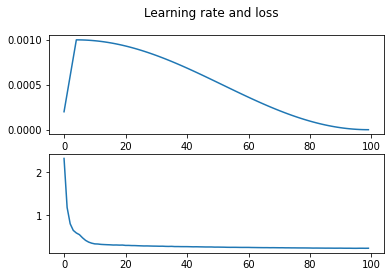

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)